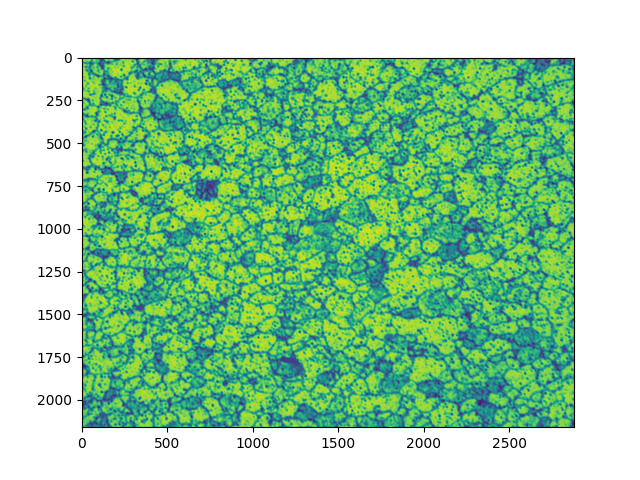

In [231]:
import numpy as np
from skimage import io
import skimage.exposure as exposure
from skimage.color import rgb2gray, label2rgb
from skimage.measure import label, regionprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import io, color, filters, morphology, feature, measure, segmentation
from scipy import ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cv2
%matplotlib ipympl

img = cv2.imread('high mag000006.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray)

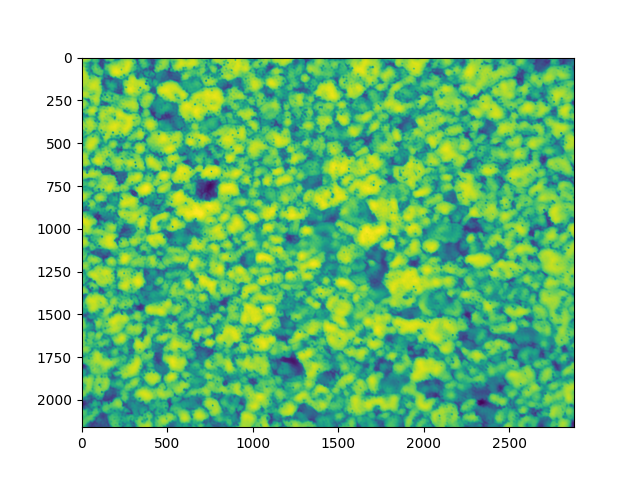

In [280]:
# Apply a bilateral filter to reduce noise
blur = cv2.bilateralFilter(gray, 50, 50, 50)
plt.figure()
plt.imshow(blur)

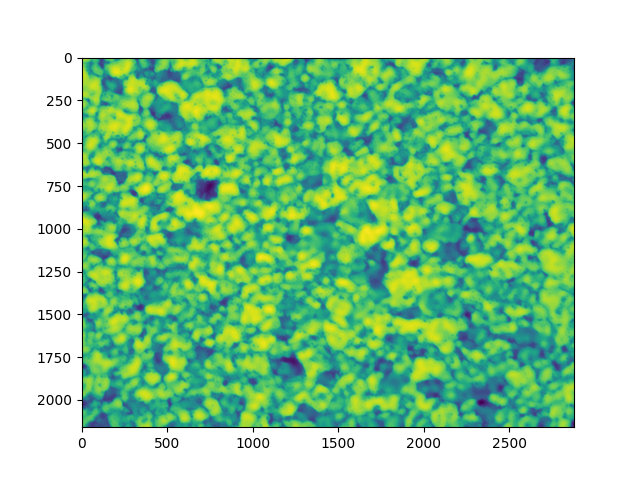

In [281]:
# Median Blur
median = cv2.medianBlur(blur, 13)
plt.figure()
plt.imshow(median)

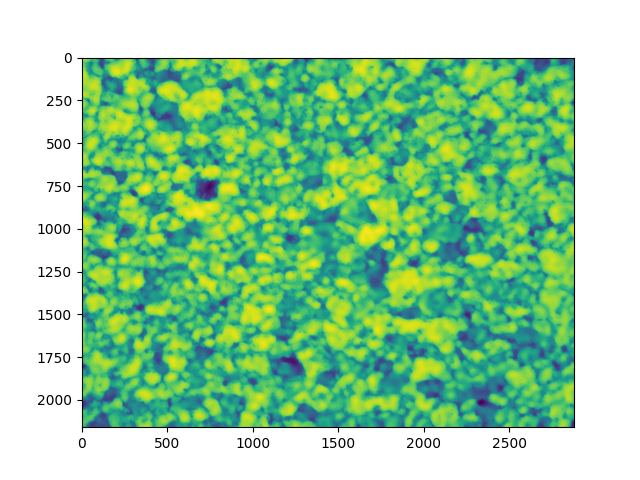

In [282]:
# Apply morphological operations to enhance edges
kernel = np.ones((7,7), np.uint8)
#kernels = [np.ones((5,5), np.uint8), np.ones((7,7), np.uint8),np.ones((9,9), np.uint8),np.ones((11,11), np.uint8),np.ones((13,13), np.uint8),np.ones((15,15), np.uint8)]
closing = cv2.morphologyEx(median, cv2.MORPH_CLOSE, kernel, iterations=1)
#fig, axs = plt.subplots(2,3,sharex=True,sharey=True)
#for i,ax in enumerate(np.ravel(axs)):
#    closing = cv2.morphologyEx(median, cv2.MORPH_CLOSE, kernels[i])
#    ax.imshow(closing)
#    ax.set_title(str(np.shape(kernels[i])))
#    ax.axis('off')
#fig.tight_layout
plt.figure()
plt.imshow(closing)

In [ ]:
#Dilation
#kernel = np.ones((1,1), np.uint8)
#dilate = cv2.dilate(closing, kernel, iterations=2)
#plt.figure()
#plt.imshow(dilate)

In [ ]:
#edges = cv2.Canny(dilate, 10, 30, 5)
#plt.figure()
#plt.imshow(edges)

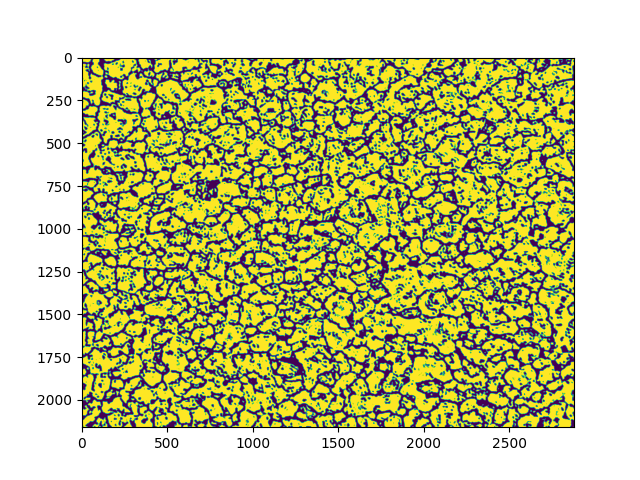

In [284]:
# Adaptive thresholding
thresh = cv2.adaptiveThreshold(closing, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 27, 1)

plt.figure()
plt.imshow(thresh)

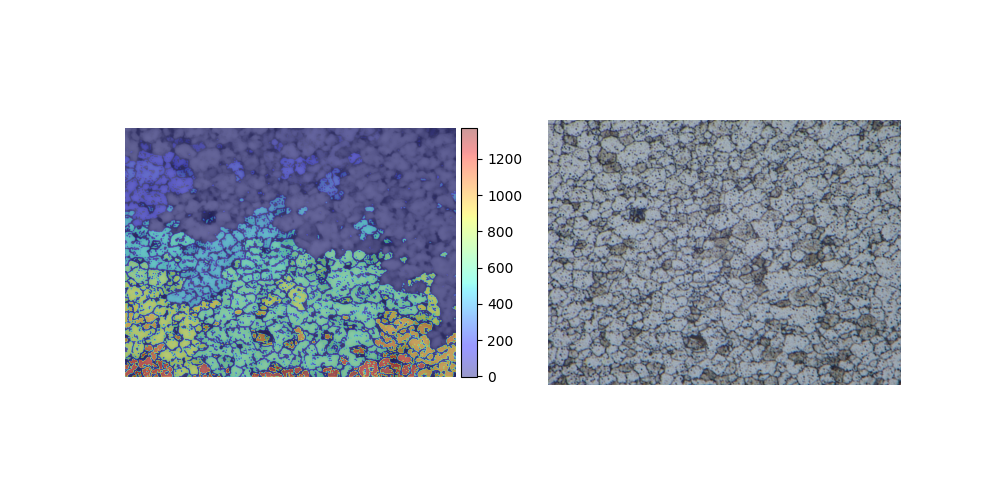

In [297]:
# Perform the watershed algorithm
dist_transform = cv2.distanceTransform(thresh,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,100)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(thresh,sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)

# Display the segmented image and the original image side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(cv2.cvtColor(closing, cv2.COLOR_BGR2RGB))
im1 = ax1.imshow(markers, alpha=0.4, cmap='jet')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.axis('off')

# Create a colorbar for the segmented image
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax)

# Set up the zooming behavior
def on_xlims_change(ax):
    xlim = ax.get_xlim()
    ax2.set_xlim(xlim)

def on_ylims_change(ax):
    ylim = ax.get_ylim()
    ax2.set_ylim(ylim)

ax1.callbacks.connect('xlim_changed', on_xlims_change)
ax1.callbacks.connect('ylim_changed', on_ylims_change)

plt.show()

In [298]:
# Measure the size of each grain
sizes = []
for i in range(1, np.max(markers)+1):
    size = np.sum(markers == i)
    sizes.append(size)

In [299]:
# Calculate the longest diameter of each grain
longest_diameters = []
for i in range(1, np.max(markers)+1):
    mask = np.uint8(markers == i)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_diameter = 0
    for cnt in contours:
        (x,y), radius = cv2.minEnclosingCircle(cnt)
        diameter = int(radius*2)
        if diameter > max_diameter:
            max_diameter = diameter
    longest_diameters.append(max_diameter)

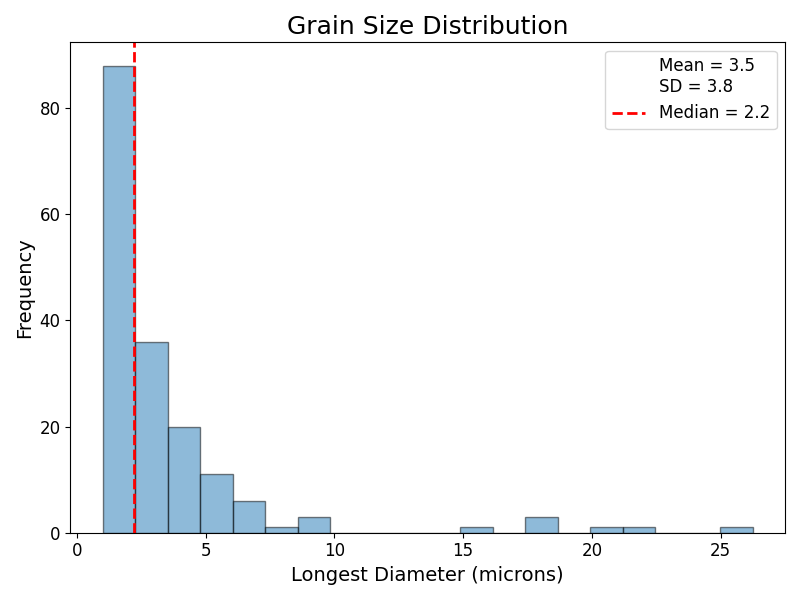

In [300]:
# Plot a histogram of the grain size distribution
# Set Scale
scale = 38.6403 # in [pixels/um]

# Remove values below threshold size
lower_threshold = 1
upper_threshold = 30

# Re-scale and create a new list with values above the threshold
longest_diameters_resized = [d / scale for d in longest_diameters]
filtered_diameters = [d for d in longest_diameters_resized if d >= lower_threshold and d <= upper_threshold]

# Define labels for legend
median_size = np.median(filtered_diameters)
mean_size = np.mean(filtered_diameters)
std_size = np.std(filtered_diameters)
mean_label = 'Mean'
median_label = 'Median'
plt.figure(figsize=(8,6))
plt.hist(filtered_diameters, bins=20, edgecolor='black', alpha=0.5)
plt.axvline(median_size, color='red', linestyle='--', linewidth=2)

handles = [plt.Rectangle((0,0),1,1,color='black',ec='black',alpha=0),
           plt.Line2D([0],[0], linestyle='--', color='red', linewidth=2)]

labels = [f'{mean_label} = {mean_size:.1f}\nSD = {std_size:.1f}',
          f'{median_label} = {median_size:.1f}']

legend_elements = handles + [Line2D([0], [0], color='green', linestyle='--', linewidth=2, label=labels[0])]

plt.title('Grain Size Distribution', fontsize=18)
plt.xlabel('Longest Diameter (microns)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.text(plt.xlim()[1]*0.8, plt.ylim()[1]*0.8, f'{mean_label} = {mean_size:.1f}\nSD = {std_size:.1f}', fontsize=12, ha='right', va='top')
plt.tight_layout()

plt.legend(handles=legend_elements, labels=labels, loc='upper right', fontsize=12)

plt.show()